In [1]:
import numpy as np
import copy
import plotly.graph_objects as go
import time
import matplotlib.pyplot as plt
from numpy import random
from numba import jit
import copy

In [2]:
#Function to create random square array
def gen_random_conf(n):
    #input: n = length of array = width of array
    #output: random 10x10 array (-1/2's and +1/2's)
    
    A = np.random.choice([-1,1], size=(n,n))
    
    return(A)

In [3]:
#Compute energy as a function of J (i.e. assume J = 1)
@jit(nopython=True)
def calculate_energy(spin):
    
    #Determine if array is square
    spin_shape = spin.shape
    
    #Should end if array is not square
    if spin_shape[0] != spin_shape[1]:
        print("This is not a square matrix")
    #Continues code if array is square    
    elif spin_shape[0] == spin_shape[1]:
        N = spin_shape[0]
        
        energy = 0
        J = 1

        for i in range(N):  # 0, N-1
          for j in range(N): # 0, N-1
            # calculate four interactions
            ii = i + -1
            if (ii < 0): 
                ii = ii + N
            if (ii >=N): 
                ii = ii - N
            energy = energy + spin[i,j]*spin[ii, j] #spin--> array name

            
            jj = j + -1
            if (jj < 0): 
                jj = jj + N
            if (jj >=N): 
                jj = jj - N
            energy = energy + spin[i,j]*spin[i, jj] 

    energy = -J * energy * 0.5
    
    return energy

In [4]:
#Sums all indices of array(magnetic sum)
def magnetism_sum(spin):
    magnetism = np.sum(spin)
    return magnetism

## Metropolis-Hastings code
Generally we want to follow this Monte Carlo algorithm to determine how the Ising array changes over time
1. Start with some given Ising array
2. Propose a random change of spin
3. Calculate the energy of the new configuration
4. Determine if change is accepted
    - if change lowers energy, accept it
    - if change raises energy, accept it *with some given probability*

There's a few different methods we can use to calculate this probability
### Statistical mechanics
Using *statistical mechanics*, the probability of finding a given state is given by
$$ P = \frac{e^{-\beta H}}{Z} $$
Where $\beta = \frac{1}{k_bT}$ and $Z$ is the **partition function**, given by 
$$ Z = \sum_{states}e^{-\beta H} $$
However, this requires calculating energies of *all of the given states*, which scales as $2^{n_{spins}}$. 

This is pretty inefficient (i.e. for a 16x16 grid, $2^{16*16}\approx n_{\text{atoms in universe}}$)

### Approximating the partition function
A more reasonable approach is to randomly sample states and approximate an *average* energy of all states $\bar{E}$, which is then used to calculate $Z$ 

$$ Z = n_{states}*\bar{E}$$

However, even this is flawed as there are more low-energy states than high-energy ones. For example, consider a randomly shuffled deck of cards. If 'disorder' is lower energy, there's many more 'disordered' configurations of the deck than 'ordered.' This makes it harder to calculate a true average

### Metropolis-Hastings algorithm

Instead of requiring us to calculate the partition function to evaluate probability, the *Metropolis-Hastings algorithm* allows us to compare **relative likelihoods** of the new and old configurations

For example, say we propose a randomly flipped spin. We can write expressions for the probability of each configuration
$$ P_{before} = \frac{e^{-\beta H_{before}}}{Z} \quad  P_{after} = \frac{e^{-\beta H_{after}}}{Z} $$

If we instead look at the relative likelihood, the difficult-to-compute partition function vanishes
$$P = \frac{P_{after}}{P_{before}} = \frac{e^{-\beta H_{after}}/Z}{e^{-\beta H_{before}}/Z} = \frac{e^{-\beta H_{after}}}{e^{-\beta H_{before}}} \quad \text{where }0<P<1$$

This solves the difficult problem of calculating the partition function by only requiring that we know a function *proportional* to the probability density, without the need for normalization

##### Generate a plotly image from an array of spins 0.5 and -0.5 (Kat)
def get_ising_plot(spin):
    img = np.array(spin, dtype = object)
    for i in range(len(spin[0])):
        for j in range(len(spin[1])):
            if spin[i,j] == 0.5:
                img[i,j] = [255,255,255]
            else:
                img[i,j] = [0,0,0]
    image = go.Image(z=img)
    return image

# Stich together plotly frames to create an animation (Kat)
def get_ising_video(frames, initial_spin):
    fig = go.Figure(
    data=[get_ising_plot(initial_spin)], 
    layout=go.Layout(
        title = "Ising model demonstration",
        xaxis = {'showticklabels':False},
        yaxis = {'showticklabels':False},
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None, dict(frame=dict(duration=20))])])]
        ), frames=frames )

    return fig                         

## Video Example of Algorithm

In [ ]:
# Test Ava's Metropolis algorithm with video of Ising plot
N = 20 # size of Ising array
n = 10000 # number of Metropolis iterations
spin = gen_random_conf(N) # initial Ising array
initial_spin = spin
frames = []

for i in range(n):    
    spin = copy.deepcopy(metro(1,spin))
    frame = go.Frame(data = get_ising_plot(spin))
    frames.append(frame)    
    
fig = get_ising_video(frames, initial_spin)
fig.show()

## Timing Tests

In [ ]:
def iteration_time(it):
    start_time_tot = time.time()
    for i in range(it):
        spin = gen_random_conf(10)
        start_time_it = time.time()
        metropolis(10, spin)
        end_time_it = time.time()

        #print("Iteration " + str(i) + ": " + str(end_time_it - start_time_it))

    end_time_tot = time.time();   
    print("It took " + str(end_time_tot-start_time_tot) + " seconds total to run " + str(it) + " iterations.")

iteration_time(10000)


In [ ]:
def time_it():
    spin = gen_random_conf(10)
    start_time_it = time.time()
    metropolis(10, spin)
    end_time_it = time.time()
    return end_time_it - start_time_it


In [ ]:
plt.ylabel("Duration (sec)")
plt.xlabel("Number of Iterations")
duration_array = []
iteration_array = []
for i in range(100):
    duration_array.append(time_it())
    iteration_array.append(i+1)


#print(duration_array)
#print(iteration_array)
plt.plot(iteration_array, duration_array)


## Standard Deviation 

$$ StandardDeviation =  <E_i^{2}> - <E>^{2}$$

In [ ]:
#Function to ccalculate standard deviatiopn of a data set
#@jit(nopython=True)
def stan_dev(data):
    #Initialize variables (values: used for (Ei^2); avg: used for <E>^2
    values = 0
    avg = 0
    #Number of values in array
    n = len(data)
    #Sums the square of each value in array 
    for i in range(n):
        values += data[i]**2
    #Finds average of the sum
    values = values/n
    #data = np.array(data)
    avg = np.average(data)

    return (values - (avg**2))**(0.5)

In [ ]:
stans = []
for i in range(1000):
    stans.append(np.random.rand())

stan_dev(stans)




# Ploting Temperature vs. Magnetization/Energy

In [5]:
#Metropolis function that uses beta as an input
#@jit(nopython = True)
#Metropolis function that uses beta as an input
@jit(nopython = True)
def metro(beta, spin):
    
    #Confirm that spin is a square array
    spin_shape = spin.shape 
    
    if spin_shape[0] != spin_shape[1]:
        print("This is not a square matrix")
        return   
    elif spin_shape[0] == spin_shape[1]:
        N = spin_shape[0]
    
    #Choose random index
    a = np.random.randint(0, N)
    b = np.random.randint(0, N)
    random =  spin[a, b]
    
    
    #Calulate difference between original isolated energy and new isolated energy
    J = 1
    before_flip = -J*(spin[(a+1)%N,b]*random + spin[a,(b+1)%N]*random + spin[(a-1)%N,b]*random + spin[a,(b-1)%N]*random)
    random = random*-1
    after_flip = -J*(spin[(a+1)%N,b]*random + spin[a,(b+1)%N]*random + spin[(a-1)%N,b]*random + spin[a,(b-1)%N]*random)
    delta = after_flip - before_flip
    
    #Deteremine randome float for comparing probability to
    chance = np.random.rand()
    
    #Accept change if: 1) energy is lowered or 2) probabilty is under random value
    if delta < 0:
        spin[a,b] *= -1
    elif chance <= np.exp(-delta*beta):
        spin[a,b] *= -1
    elif chance >np.exp(-delta*beta):
        spin[a,b] *= 1
        
    return spin



In [6]:
#Parameters

#Number of temperature points on graph
temp_point = 50 #Prof. Strachan recomended 50 tmep points
#Size of lattice
N = 10
#Number of Metropolis sweeps performed
equi_iterations = 1000
metro_iterations = 100000
#Temperate range
T = np.linspace(0.0001, 5, temp_point);
#Creates arrays to store magetism/energy points
M = np.zeros(temp_point)
E = np.zeros(temp_point)
#Create arrays to store standard deviation
mag_std = np.zeros(temp_point)
ene_std = np.zeros(temp_point)

In [7]:
start_time_tot = time.time()
for x in range(temp_point):  
    #Initalizes array for each temperature point
    spin = gen_random_conf(N)
    #Calculates beta for each temperature point
    new_beta=1.0/(T[x]) 
    
    #Counts metro steps run for each temperature point
    s = 0
    
    

    #final_mag = []
    #final_ene = []
    ave_energy, ave_energy2, ave_mag, ave_mag2 = 0,0,0,0
    count = 0
    
    #Equilibriation
    for i in range(equi_iterations):
        spin = metro(new_beta, spin) 
    #Metropolis sweeps 
    for i in range(metro_iterations):
        
        s += 1
        
        #Inner for loop used to record only every 10 MC sweeps
        spin = metro(new_beta, spin)
        if s%10 == 0:
            
        #Calculates magnetism/energy for each temperature point
            mag = magnetism_sum(spin) 
            ene = calculate_energy(spin)
            ave_energy += ene
            ave_energy2 += ene*ene
            ave_mag += mag
            ave_mag2 += mag*mag
            count += 1
    
    #Take average of all sampled points for given temperature
    ave_energy = ave_energy/(count)
    ave_energy2 = ave_energy2/(count)
    ave_mag = ave_mag/(count)
    ave_mag2 = ave_mag2/(count)
    
    #Append standard deviation to array
    ene_std[x] = np.sqrt(ave_energy2 - ave_energy*ave_energy)
    mag_std[x] = np.sqrt(ave_mag2 - ave_mag*ave_mag)
    
    
    #Divide by number of sites and append to array
    M[x] = (1/(N**2))*ave_mag
    E[x] = (1/(N**2))*ave_energy
    
end_time_tot = time.time();

print (np.average(ene_std))
print (np.average(mag_std))

print("It took " + str(end_time_tot-start_time_tot) + " seconds total to run " + str(metro_iterations) + " iterations.")

7.408685379823448
21.466082974887577
It took 11.994853019714355 seconds total to run 100000 iterations.


In [11]:
#Main code

k = 8.617E-5 #Boltzman constant (eV/K)
#T = 300 #K

beta = 1 #J/kT
#Number of configurations that will contribute to averages
iterations = 100000
#Array size
N = 10

#Intializing arrays
beta_array, temp_array, energy_array, mag_array = [], [], [], []

#Determing beta based on temperature & initializing variables/resetting variables after each loop
for temp in np.linspace(0.0001, 5, 50):
    beta = 1/temp
    energy = 0.
    magnetism = 0. 
    denominator = 0. 
    
    #Generates given number of configurations and considers their energies/magnetizations in the averages
    for i in range(iterations):
        #Creates new random configuration
        spin = gen_random_conf(N)
        
        #Calculates the magnetism of configuration
        mag = np.sum(spin)/N/N 

        #Calculates the energy of configuration
        e = calculate_energy(spin)
        
        #Determines bolztman weight
        boltz = np.exp(-1*beta*e)
        #Values are included in the summations(numerators of equations for avg. magetism and energy)
        energy += e * boltz
        magnetism += mag * boltz
        denominator += boltz
    
    #Calculates average magnetism and energy
    magnetism = magnetism/denominator
    energy = energy/denominator



    #Adds values to arrays
    beta_array.append(beta)
    temp_array.append(1/beta)
    energy_array.append(energy)
    mag_array.append(magnetism)

/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars


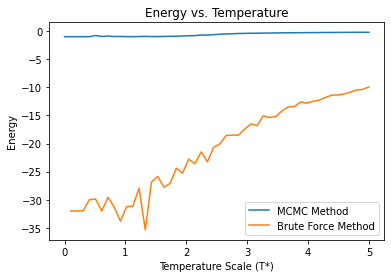

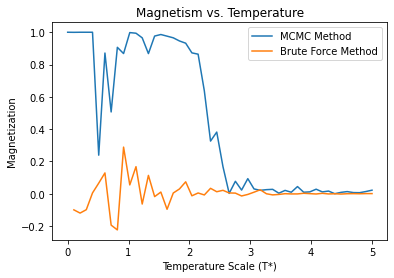

In [12]:
plt.title("Energy vs. Temperature") 
plt.xlabel("Temperature Scale (T*)"); 
plt.ylabel("Energy"); 
plt.plot(temp_array, E) 
plt.plot(temp_array, energy_array)
plt.legend(["MCMC Method", "Brute Force Method"])
plt.show()

plt.title("Magnetism vs. Temperature")  
plt.xlabel("Temperature Scale (T*)"); 
plt.ylabel("Magnetization"); 
plt.plot(temp_array, abs(M))
plt.plot(temp_array, mag_array)
plt.legend(["MCMC Method", "Brute Force Method"])
plt.show()



#Standard Deviation Histograms

